In [1]:
import numpy as np
from scipy import optimize as opt, linalg as la
from scipy.stats import norm
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
time_series_a = np.loadtxt('time_series_a.txt')
time_series_b = np.loadtxt('time_series_b.txt')
time_series_c = np.loadtxt('time_series_c.txt')

# Problem 1

In [3]:
def arma_likelihood(time_series, phis=np.array([]), 
                    thetas=np.array([]), mu=0., sigma=1.):
    """
    Return the log-likelihood of the ARMA model parameters, given the time
    series.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    
    Returns
    -------
    log_likelihood : float
        The log-likelihood of the model
    """
    z = time_series - mu
    
    # get parameters for the sizes of everything
    p = phis.shape[0]
    q = thetas.shape[0]
    r = np.max([p,q+1])
    d = z.ndim
    
    if phis.size>0:
        phis = np.concatenate((phis,np.zeros(r-p)))
    if thetas.size>0:
        thetas = np.concatenate((thetas,np.zeros(r-1-q)))
    
    # set up necessary matrices
    bottom = np.concatenate((np.eye(r-1),np.zeros(r-1).reshape((r-1,1))),
                            axis=1) # this is the bottom of the F matrix
    F = np.concatenate((phis.reshape((1,r)),bottom),axis=0)
    H = np.concatenate(([1],thetas)).reshape((1,r))
    Q = np.zeros((r,r))
    Q[0,0] = sigma**2
    #print(F)
    #print(H)
    #print(Q)
    
    # 
    xkp = np.zeros(r)
    flatPkp = la.solve(np.eye(r**2) - np.kron(F,F), Q.flatten())
    Pkp = flatPkp.reshape((r,r))
    
    loglikelihood = 0
    
    for k in range(0,len(z)):
        # Update
        yk = z[k] - H.dot(xkp)
        Sk = H.dot(Pkp.dot(H.T))
        Kk = la.solve(Sk.T, H.dot(Pkp.T)).T
        
        loglikelihood += norm.logpdf(z[k], H.dot(xkp), np.sqrt(H.dot(Pkp.dot(H.T))))
        
        xku = xkp + Kk.dot(yk)
        Pku = (np.eye(r) - Kk.dot(H)).dot(Pkp)

        # Predict
        xkp = F.dot(xku)
        Pkp = F.dot(Pku.dot(F.T)) + Q

    return loglikelihood

In [4]:
arma_likelihood(time_series_a, np.array([0.9]), mu=17., sigma=.4)

array([[-77.60354497]])

# Problem 2

In [12]:
def arma_fit(time_series):
    """
    Return the ARMA model that minimizes AICc for the given time series,
    subject to p,q <= 3.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
        
    Returns
    -------
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    """
    n = time_series.shape[0]
    pstar, qstar = -1, -1
    min_aicc = 9999
    for p in range(1,4):
        for q in range(1,4):
            def f(x):
                return -1*arma_likelihood(time_series, phis=x[:p], 
                                          thetas=x[p:p+q], 
                                          mu=x[-2], sigma=x[-1])
            k = p + q + 2
            x0 = np.zeros(p+q+2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            sol = opt.fmin(f,x0,maxiter=10000,maxfun=10000, 
                           disp=False, retall=False)
            aicc = 2*k*(1 + (k+1)/(n-k)) + 2*f(sol)
            #print(p,q,aicc)
            if aicc < min_aicc:
                parameters = sol
                pstar = p
                qstar = q
                min_aicc = aicc
    return (parameters[:pstar], 
            parameters[pstar:pstar+qstar], 
            parameters[-2], 
            parameters[-1])

In [13]:
paramsA = arma_fit(time_series_a)
print(('Time Series A:\np - {}\n'+
       'q - {}\nmu - {}\nsigma - {}').format(paramsA[0], paramsA[1],
                                             paramsA[2], paramsA[3]))

C:\Users\matts\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1695: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1696: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:555: RuntimeWarning: invalid value encountered in less
  if fxe < fxr:
C:\User

Time Series A:
p - [0.90867024]
q - [-0.57585945]
mu - 17.065262486340927
sigma - 0.31253098628150655


In [14]:
paramsB = arma_fit(time_series_b)
print(('Time Series B:\np - {}\n'+
       'q - {}\nmu - {}\nsigma - {}').format(paramsB[0], paramsB[1],
                                             paramsB[2], paramsB[3]))

C:\Users\matts\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1695: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1696: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:551: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[0]:
C:\

Time Series B:
p - [ 0.2350456 -0.3839864 -0.6566961]
q - [-0.20234983  0.41060419  0.67314649]
mu - -0.2853804404204241
sigma - 7.033452537536814


In [15]:
paramsC = arma_fit(time_series_c)
print(('Time Series C:\np - {}\n'+
       'q - {}\nmu - {}\nsigma - {}').format(paramsC[0], paramsC[1],
                                             paramsC[2], paramsC[3]))

C:\Users\matts\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1695: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1696: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\matts\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:555: RuntimeWarning: invalid value encountered in less
  if fxe < fxr:
C:\User

Time Series C:
p - [ 1.22481184 -0.56007884]
q - [0.38466735]
mu - 48.46227811120798
sigma - 14.622537558888457


# Problem 4

In [17]:
def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0.,
sigma=1., future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    future_periods : int
    The number of future periods to return
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
    The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
    The standard deviations of z for times n+1, ..., n+future_periods
    """
    z = time_series - mu
    evals = np.zeros(future_periods)
    sigs = np.zeros(future_periods)
    
    #Set the parameters for the model
    d = time_series.ndim 
    n = time_series.shape[0]
    p = phis.shape[0]
    q = thetas.shape[0]
    r = np.max([p,q+1])
    
    F = np.diag(np.ones(r-1), -1)
    F[0,:p] = phis
    
    H = np.zeros([d,r])
    H[0,0] = 1
    H[0,1:(q+1)] = thetas

    Q = np.zeros([r,r])
    Q[0,0] = sigma**2   
    
    xt = np.zeros(r)
    Pt = np.linalg.solve(np.eye(r**2) - np.kron(F,F), Q.flatten()).reshape(r,r)
    
    # Now find x_n, P_n
    for t in range(n):
        # Update
        yt = z[t].ravel() - H.dot(xt).ravel()
        St = H.dot(Pt.dot(H.T))
        Kt = np.linalg.solve(St.T, H.dot(Pt.T)).T
        xt1 = xt.ravel() + Kt.dot(yt).ravel()
        Pt1 = (np.eye(r) - Kt.dot(H)).dot(Pt)

        # Predict
        xt = F.dot(xt1).ravel()
        Pt = F.dot(Pt1.dot(F.T)) + Q
    
    for t_f in range(future_periods):
        # Predict
        xt = F.dot(xt).ravel()
        Pt = F.dot(Pt.dot(F.T)) + Q
        
        #Now calculate mean and variance
        evals[t_f] = H.dot(xt) + mu
        sigs[t_f] = np.sqrt(H.dot(Pt.dot(H.T)))
    return evals, sigs

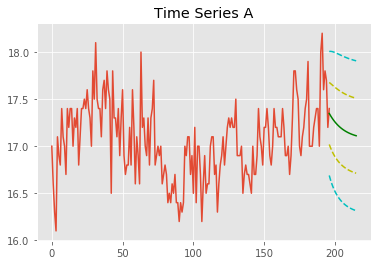

In [30]:
phiA, thetaA, muA, sigmaA = paramsA
future_states = 20

a4mu, a4sig = arma_forecast(time_series_a, phiA, thetaA, 
                            muA, sigmaA, future_states)
domain = np.arange(len(time_series_a))
plt.plot(domain, time_series_a)

#Now plot the predictions
domain2 = np.arange(domain[-1], domain[-1]+future_states)
plt.plot(domain2, a4mu, 'g')
plt.plot(domain2, a4mu+a4sig, 'y--')
plt.plot(domain2, a4mu-a4sig, 'y--')
plt.plot(domain2, a4mu+2*a4sig, 'c--')
plt.plot(domain2, a4mu-2*a4sig, 'c--')
plt.title('Time Series A')
plt.show()

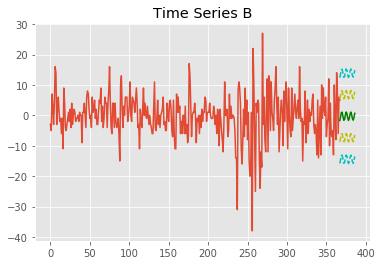

In [32]:
phiB, thetaB, muB, sigmaB = paramsB
b4mu, b4sig = arma_forecast(time_series_b, phiB, thetaB, 
                            muB, sigmaB, future_states)
domain = np.arange(len(time_series_b))
plt.plot(domain, time_series_b)

#Now plot the predictions
domain2 = np.arange(domain[-1], domain[-1]+future_states)
plt.plot(domain2, b4mu, 'g')
plt.plot(domain2, b4mu+b4sig, 'y--')
plt.plot(domain2, b4mu-b4sig, 'y--')
plt.plot(domain2, b4mu+2*b4sig, 'c--')
plt.plot(domain2, b4mu-2*b4sig, 'c--')
plt.title('Time Series B')
plt.show()

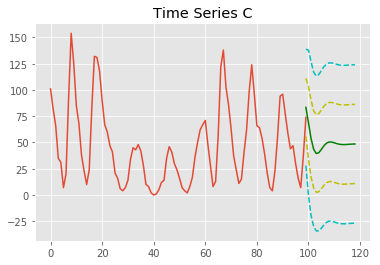

In [34]:
phiC, thetaC, muC, sigmaC = paramsC
c4mu, c4sig = arma_forecast(time_series_c, phiC, thetaC, 
                            muC, sigmaC, future_states)
domain = np.arange(len(time_series_c))
plt.plot(domain, time_series_c)

#Now plot the predictions
domain2 = np.arange(domain[-1], domain[-1]+future_states)
plt.plot(domain2, c4mu, 'g')
plt.plot(domain2, c4mu+c4sig, 'y--')
plt.plot(domain2, c4mu-c4sig, 'y--')
plt.plot(domain2, c4mu+2*c4sig, 'c--')
plt.plot(domain2, c4mu-2*c4sig, 'c--')
plt.title('Time Series C')
plt.show()